# 項目 : Google 股票資料分析專案（2015–2024）




## 分析目標

本專案使用 Google股票於 2015 至 2024 年的歷史股價資料進行探索性資料分析（EDA）與視覺化展示。透過時間序列趨勢圖與簡易技術指標，觀察其長期變化趨勢、年度報酬差異與短期波動特性。

分析重點包括：
- 收盤價趨勢圖（Close Price Trend）
- 移動平均線視覺化
- 每年漲跌幅統計與視覺比較
- 成交量與波動變化的對照分析

## 資料簡介

本資料來源於 [Kaggle: Google Stock Prices 2015–2024](https://www.kaggle.com/datasets/youssefelebiary/google-stock-prices-2015-2024)，記錄了 Google 股票在 2015 年至 2024 年間每日的市場交易資訊。

原始資料檔案名稱：`GoogleStockPrices.csv`

### 欄位說明：

- `Date`：交易日期
- `Open`：開盤價
- `High`：當日最高價
- `Low`：當日最低價
- `Close`：收盤價
- `Adj Close`：調整後收盤價（考慮拆股、配息等）
- `Volume`：成交量（單位為股數）


## 讀取資料與初步檢查

首先使用 `pandas` 讀取 Google 股票資料的 CSV 檔案，觀察資料的基本結構、欄位內容、資料型別與是否有缺漏值等，建立對整體資料的初步認識。


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df = pd.read_csv("GoogleStockPrices.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,2015-01-02 16:00:00,26.63,26.79,26.39,26.48,1327870
1,2015-01-05 16:00:00,26.36,26.40,25.89,25.97,2059119
2,2015-01-06 16:00:00,26.02,26.06,25.28,25.33,2731813
3,2015-01-07 16:00:00,25.55,25.57,25.18,25.26,2345875
4,2015-01-08 16:00:00,25.08,25.38,24.75,25.35,3662224


## 資料前處理（轉換日期欄與設定索引）

為了方便後續做時間序列分析與畫圖，我們會將 `Date` 欄位轉為日期格式，並設定為 DataFrame 的索引值。這樣可以讓資料依照時間排序，也能讓圖表的 X 軸自動對應時間。


In [18]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()
df.index


DatetimeIndex(['2015-01-02 16:00:00', '2015-01-05 16:00:00',
               '2015-01-06 16:00:00', '2015-01-07 16:00:00',
               '2015-01-08 16:00:00', '2015-01-09 16:00:00',
               '2015-01-12 16:00:00', '2015-01-13 16:00:00',
               '2015-01-14 16:00:00', '2015-01-15 16:00:00',
               ...
               '2024-12-17 16:00:00', '2024-12-18 16:00:00',
               '2024-12-19 16:00:00', '2024-12-20 16:00:00',
               '2024-12-23 16:00:00', '2024-12-24 13:05:00',
               '2024-12-26 16:00:00', '2024-12-27 16:00:00',
               '2024-12-30 16:00:00', '2024-12-31 16:00:00'],
              dtype='datetime64[ns]', name='Date', length=2516, freq=None)

## 資料清理（缺值、重複與異常值檢查）
在進行資料分析前，首先需要確認資料中是否存在缺失值。缺失值可能會導致統計結果不準確，或在視覺化與建模時產生錯誤。

使用 `df.info()` 方法可以快速檢視每個欄位的非空值筆數；若非空值筆數小於總筆數，即表示該欄位有缺失資料。



In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-01-02 16:00:00 to 2024-12-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2516 non-null   float64
 1   High    2516 non-null   float64
 2   Low     2516 non-null   float64
 3   Close   2516 non-null   float64
 4   Volume  2516 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


接著也可以搭配 isnull().sum() 更明確地列出哪些欄位有缺值：

In [20]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [21]:
df.index.duplicated().sum()

0

所有欄位都為 0，代表目前資料集中無缺失值和重複資料，可以進入下一步分析。

## 收盤價趨勢圖

為了觀察 Google 股票在 2015 至 2024 年間的價格變動趨勢，我們使用折線圖呈現每日的收盤價。

藉由這張圖，可以清楚看到：
- 股價的長期變化（趨勢線）
- 是否有明顯的波段漲跌
- 哪些時間點出現高峰或低谷

這張圖將成為後續移動平均、報酬率分析的重要基礎。


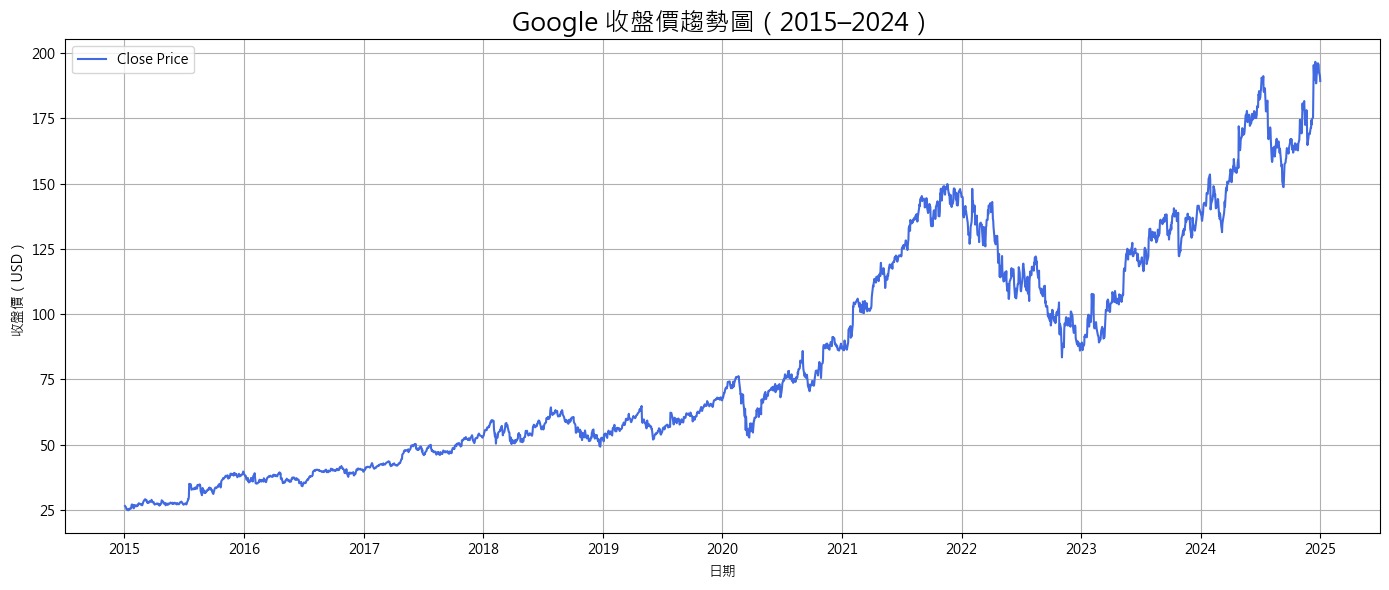

In [22]:
plt.rcParams['font.family'] = 'Microsoft JhengHei' 
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price', color='royalblue')
plt.title('Google 收盤價趨勢圖（2015–2024）', fontsize=18)
plt.xlabel('日期')
plt.ylabel('收盤價（USD）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 平均線分析（7日、14日、30日）

為了觀察不同期間內的股價變化趨勢，本報告選擇以 7、14、30 日作為移動平均週期，分別對應於：
- **7 日移動平均（MA_7）**：反映一週內短期波動趨勢，線條較靈敏。
- **14 日移動平均（MA_14）**：約等於雙週趨勢，平滑度適中。
- **30 日移動平均（MA_30）**：代表一個月內的平均價格，用於觀察中期走勢。

移動平均線的應用有助於消除短期雜訊、平滑價格曲線，也常被用於判斷趨勢轉折點。


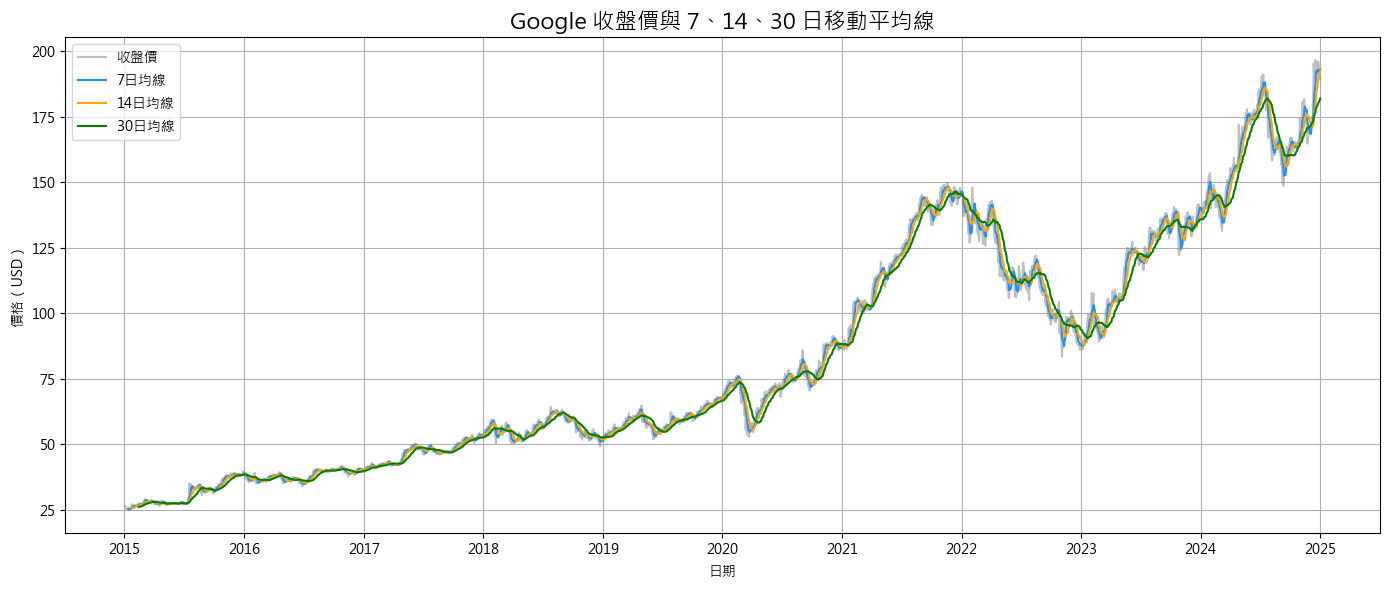

In [23]:
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_14'] = df['Close'].rolling(window=14).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
plt.figure(figsize=(14,6))
plt.plot(df['Close'],label='收盤價',color='gray',alpha=0.5)
plt.plot(df['MA_7'], label='7日均線', color='dodgerblue')
plt.plot(df['MA_14'], label='14日均線', color='orange')
plt.plot(df['MA_30'], label='30日均線', color='green')
plt.title('Google 收盤價與 7、14、30 日移動平均線', fontsize=16)
plt.xlabel('日期')
plt.ylabel('價格（USD）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 每年漲跌幅統計與視覺比較

為了了解 Google 股票在 2015 至 2024 年的年度報酬表現，我們計算每年第一筆與最後一筆收盤價的漲跌幅，並使用長條圖視覺化。

C:\Users\lcxuan\AppData\Local\Temp\ipykernel_22480\1514121814.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='Return', data=annual_change, palette='coolwarm')
C:\Users\lcxuan\AppData\Local\Temp\ipykernel_22480\1514121814.py:15: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
C:\Users\lcxuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


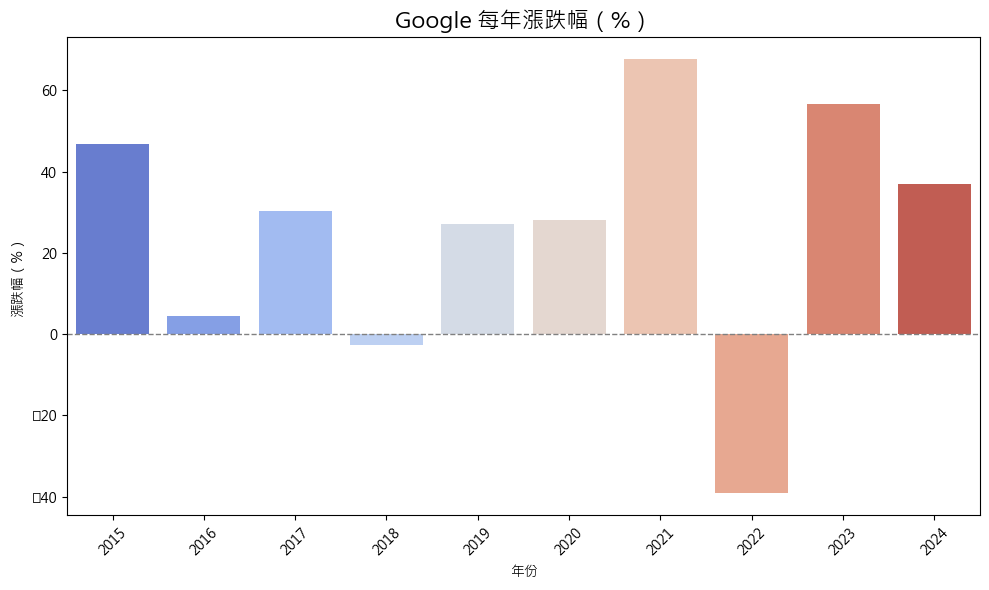

In [24]:
annual_change = (
    df['Close']
    .groupby(df.index.year) 
    .agg(Start_Price='first', End_Price='last')  
    .assign(Return=lambda t: (t['End_Price'] - t['Start_Price']) / t['Start_Price'] * 100)
    .reset_index(names='Year')  
)
plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='Return', data=annual_change, palette='coolwarm')
plt.title('Google 每年漲跌幅（%）', fontsize=16)
plt.ylabel('漲跌幅（%）')
plt.xlabel('年份')
plt.axhline(0, color='gray', linestyle='--', linewidth=1) 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

像 2021 年、2023 年呈現大幅上漲，是值得關注的高成長年度。
 2022 年明顯為修正年，跌幅超過 30%。


## 上漲與下跌年度比例分析
為了簡明呈現 Google 每年報酬率的整體分佈情況，本圖透過餅圖統計 2015–2024 年各年度中：

上漲年：指該年度股價年初至年末呈現正報酬，表示全年股價上漲。

下跌年：指該年度股價年初至年末報酬為 0 或負值，表示全年股價持平或下跌。

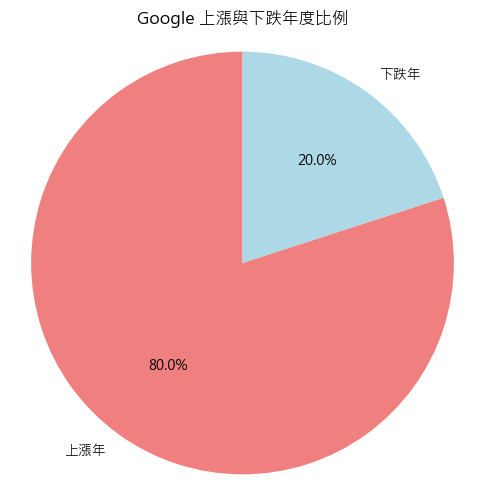

In [26]:
labels = ['上漲年', '下跌年']
counts = [
    (annual_change['Return'] > 0).sum(),
    (annual_change['Return'] <= 0).sum()
]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['lightcoral', 'lightblue'], startangle=90)
plt.title('Google 上漲與下跌年度比例')
plt.axis('equal')  
plt.show()


圖中以 淺紅色 表示上漲年份，淺藍色 表示下跌年份，圓餅圖的比例代表不同類型年度的出現次數與占比，便於觀察過去十年股價走勢的整體趨勢傾向。

## 成交量與波動變化的對照分析
為了觀察股價波動是否與市場交易熱度（成交量）有關，本圖比較了 Google 每日的：
日內波動幅度（High - Low）：反映該日價格震盪區間，代表市場的不穩定程度或消息面影響。
成交量（Volume）：表示市場參與程度與買賣力量，成交量越大，市場關注度越高。

C:\Users\lcxuan\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.draw()
C:\Users\lcxuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


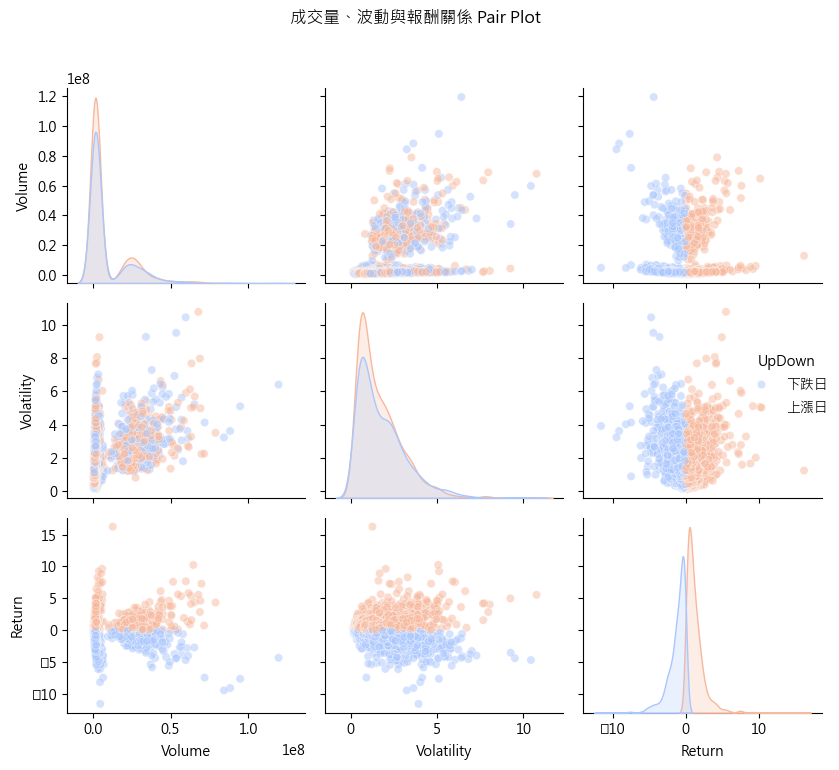

In [30]:
df['Return'] = df['Close'].pct_change() * 100  
df['Volatility'] = df['High'] - df['Low']
df['UpDown'] = df['Return'].apply(lambda x: '上漲日' if x > 0 else '下跌日')

sns.pairplot(
    df[['Volume', 'Volatility', 'Return', 'UpDown']].dropna(),
    hue='UpDown',
    palette='coolwarm',
    diag_kind='kde',
    plot_kws={'alpha': 0.5}
)

plt.suptitle('成交量、波動與報酬關係 Pair Plot', y=1.02)
plt.tight_layout()
plt.show()



本圖透過 Pair Plot 同時觀察成交量（Volume）、波動幅度（Volatility）與當日報酬（Return）三者之間的相互關係。以每日是否為上漲日進行分類，可視覺化不同漲跌類型的行為特徵。整體上，上漲日與下跌日在波動與成交量上的分布略有區別，顯示市場行為與波動風險具一定關聯性。

## 結論與後續方向
本次分析透過視覺化手法，從收盤價趨勢、移動平均線、年度漲跌幅、成交量與波動等多角度，深入探索 Google 股票的歷年表現與市場行為。重點結果如下：

收盤價趨勢：長期呈現震盪上升走勢，但個別年份報酬差異大。

移動平均線分析：短中期均線（7日、14日、30日）展現趨勢穩定與反轉點。

年度漲跌幅：透過長條圖與餅圖，清楚呈現上漲年與下跌年分布比例。

成交量與波動關係：Pair Plot 呈現出在高波動或高成交量區間，上下漲日的分布可能不同，揭示潛在風險訊號。

透過這些視覺化，我們不僅掌握歷史走勢，也建立對於市場波動與交易熱度的敏感度。

